In [75]:
# !pip install gymnasium
# !pip install gymnasium[toy-text]
# !pip install tqdm #just for progress bar
# !pip install icecream #just for debugging

In [76]:
from icecream import ic
#check versions
import gymnasium as gym
print(f'Gymnasium v{gym.__version__}')
import sys; print(f'Python v{sys.version}')

from gymnasium.envs.toy_text.frozen_lake import generate_random_map
#create env
env=gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode='rgb_array') #specific map
#env=gym.make('FrozenLake-v1', desc=generate_random_map(4), map_name="4x4", is_slippery=True, render_mode='rgb_array')
#env=gym.make('Blackjack-v1',render_mode='rgb_array')
#env=gym.make('CliffWalking-v0',render_mode='rgb_array')
#env=gym.make('Taxi-v3',render_mode='rgb_array')

done=False
observation, info = env.reset()

Gymnasium v0.29.0
Python v3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]


In [77]:
# #Just some manual tests
# import matplotlib.pyplot as plt
# if terminated or truncated:
#     env.reset()
# obs, reward, terminated, truncated, info =env.step(1)
# print(obs)
# print(reward)

# img=env.render()
# fig, ax=plt.subplots()
# ax.imshow(img)
# ax.set_title('Game')
# ax.axis('off')
# plt.show()

In [78]:
import numpy as np
from collections import defaultdict

from IPython.display import clear_output
from tqdm import tqdm
from gymnasium.wrappers import RecordEpisodeStatistics
import matplotlib.pyplot as plt


class TD_zero_for_Qvalue:
    def __init__(
        self,
        learning_rate: float=0.01,
        initial_epsilon: float=1,
        epsilon_decay: float=0.0001,
        final_epsilon: float=0.0001,
        discount_factor: float = 0.95,
        n_episodes: int=10000,
        env_stat: RecordEpisodeStatistics=env,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values=defaultdict(lambda: np.zeros(env_stat.action_space.n)) #everytime new statevalue added the lambda function is called to create a np vector of q values (initialized to zero)
        self.lr = learning_rate #the bigger the more oscillations q_values
        self.discount_factor = discount_factor 
        self.epsilon = initial_epsilon 
        self.epsilon_decay = epsilon_decay #linear decay until reaches final_epsilon
        self.final_epsilon = final_epsilon #approximately zero 
        self.n_episodes= n_episodes
        self.env_stat=env_stat
        self.training_error=[] #temporale differences (when small, no further improvements)
    def get_action(self, obs) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        if np.random.random()<self.epsilon:
            return self.env_stat.action_space.sample()
        else:
            return int(np.argmax(self.q_values[obs]))
    def update(self, obs, action, reward, terminated, next_obs):
        """Updates the Q-values with Temporal Difference"""
        future_q_value=(not terminated) * np.max(self.q_values[next_obs])
        temporal_difference= reward+ self.discount_factor*future_q_value-self.q_values[obs][action]
        self.q_values[obs][action]=self.q_values[obs][action] + self.lr*temporal_difference
        self.training_error.append(temporal_difference) 
    def linear_decay(self):
        self.epsilon=max(self.final_epsilon, self.epsilon-self.epsilon_decay)
    def exponential_decay(self): 
        self.epsilon= self.epsilon*self.epsilon_decay

        
    def train(self):
        for episode in tqdm(range(self.n_episodes)):
            obs, info = self.env_stat.reset()
            done = False

            # play one episode
            while not done:
                action = self.get_action(obs)
                next_obs, reward, terminated, truncated, info = self.env_stat.step(action)

                #update agent policy at each step
                self.update(obs, action, reward, terminated, next_obs)
                done= terminated or truncated
                obs=next_obs
                if info.get('TimeLimit.truncated', False):
                    done = True  # Terminate the episode if max episode steps are reached
            self.linear_decay()
            #ic(self.epsilon)

    def plot(self, rolling_length=100):
        fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
        axs[0].set_title("Episode rewards")
        reward_moving_average = (
            np.convolve(
                np.array(self.env_stat.return_queue).flatten(), np.ones(rolling_length), mode="valid"
            )
            / rolling_length
        )
        axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
        axs[1].set_title("Episode lengths")
        length_moving_average = (
            np.convolve(
                np.array(self.env_stat.length_queue).flatten(), np.ones(rolling_length), mode="same"
            )
            / rolling_length
        )
        axs[1].plot(range(len(length_moving_average)), length_moving_average)
        axs[2].set_title("Training Error")
        training_error_moving_average = (
            np.convolve(np.array(self.training_error), np.ones(rolling_length), mode="same")
            / rolling_length
        )
        axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
        title= "learning_rate= "+str(self.lr)+ ", n_episonde= "+ str(self.n_episodes)
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()



In [79]:
# hyperparameters
learning_rate = 0.01
n_episodes = 10000
start_epsilon = 1.0
final_epsilon = 0.001
epsilon_decay = start_epsilon/n_episodes  # reduce the exploration over time linearly
#epsilon_decay= final_epsilon**(1/n_episodes) #with n_episodes updates epsilon reaches 0.000001


# Define the maximum number of steps per episode
max_episode_steps = 1000

from gym.wrappers import TimeLimit
# Wrap the environment with the TimeLimit wrapper
env = TimeLimit(env, max_episode_steps=max_episode_steps)

env_stat = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
agent1=TD_zero_for_Qvalue(
    n_episodes=n_episodes,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    env_stat=env_stat,)

In [80]:
agent1.train()

100%|██████████| 10000/10000 [00:03<00:00, 2504.57it/s]


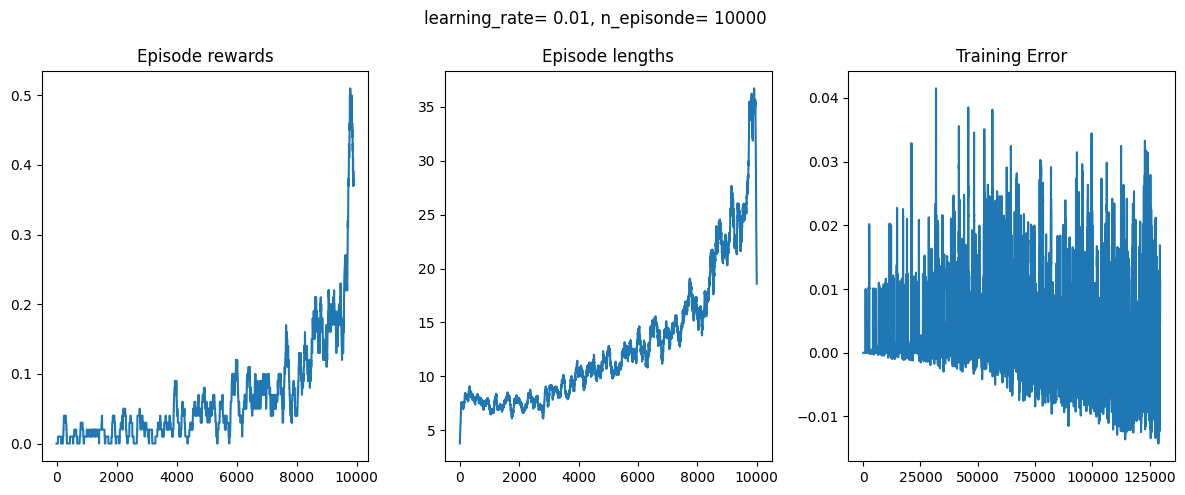

In [81]:
import matplotlib.pyplot as plt
agent1.plot(100)

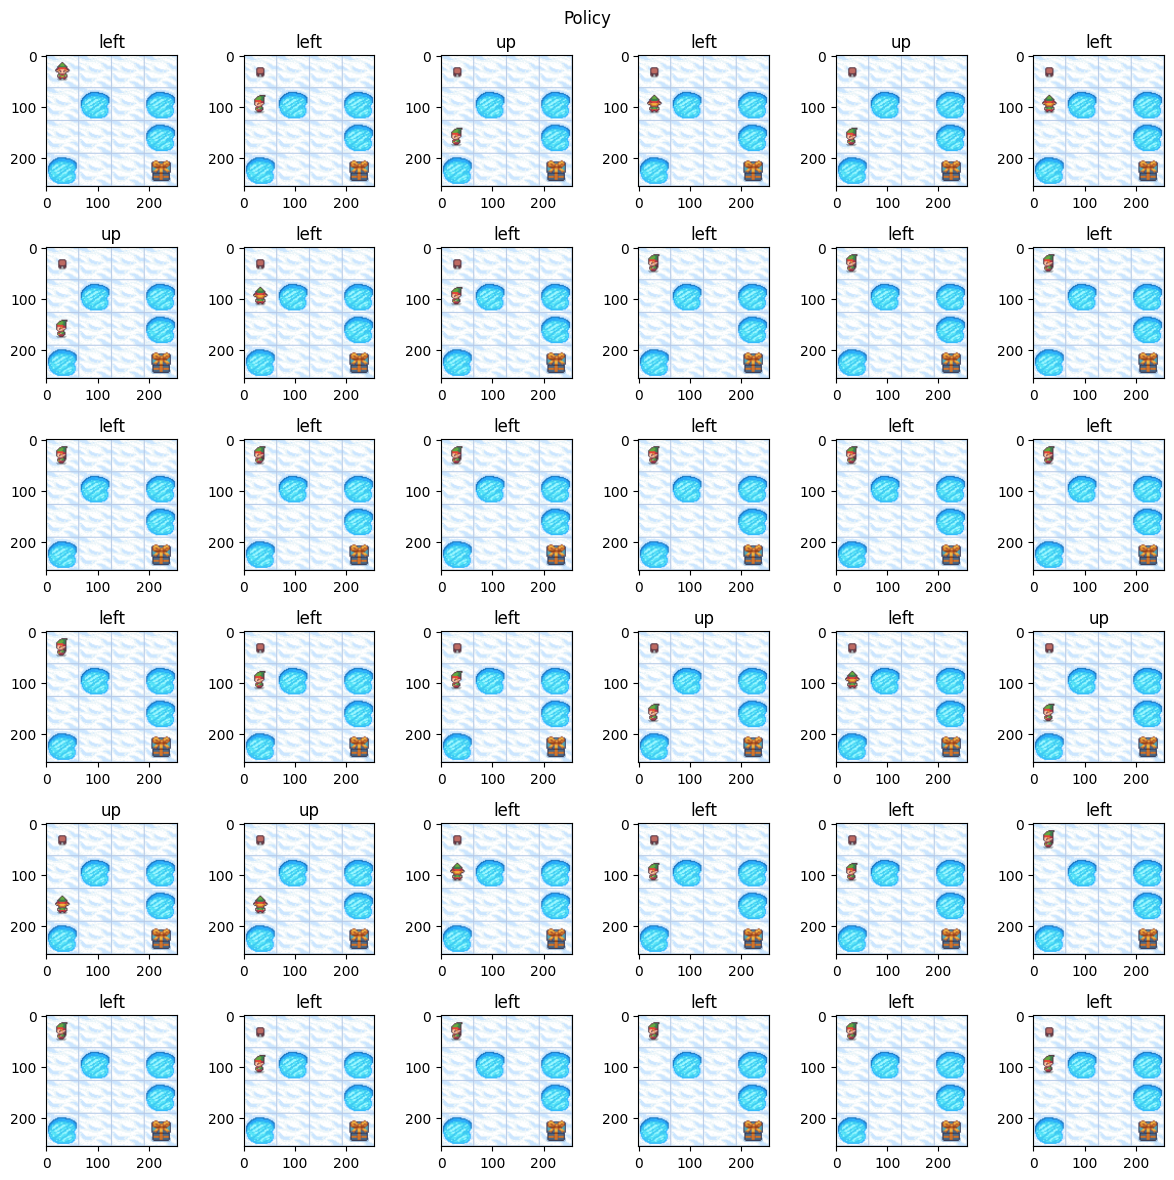

In [82]:
fig, axs = plt.subplots(ncols=6, nrows=6, figsize=(12, 12))

obs, info = env_stat.reset()
done = False
for i in range(6):
    for j in range(6):
        img=env_stat.render()
        done= terminated or truncated
        if done:
            obs, info = env_stat.reset()
        axs[i,j].imshow(img)

        action = agent1.get_action(obs)
        if action==0:
            axs[i,j].set_title("left")
        if action==1:
            axs[i,j].set_title("down")
        if action==2:
            axs[i,j].set_title("right")
        if action==3:
            axs[i,j].set_title("up")
        next_obs, reward, terminated, truncated, info = env_stat.step(action)
        obs=next_obs
        #agent1.update(obs, action, reward, terminated, next_obs)        
plt.suptitle('Policy') 
plt.tight_layout()
plt.show()